In [ ]:
# Copyright (C) 2021 Artefact
# licence-information@artefact.com

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import os 
import cv2
from datetime import date
import json
import itertools

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel
import utm
import pandas as pd

# Step 1 : Select the satellite data source

No code required in this step

# Step 2 : Collect the satellite imagery data 


### Exploring data

In [29]:
geojson_path = "../data/target_zone.geojson"

with open("../secrets/sentinel_api_credentials.json", "r") as infile:
    credentials = json.load(infile)

api = SentinelAPI(credentials["username"], credentials["password"], "https://scihub.copernicus.eu/dhus")

shape = geojson_to_wkt(read_geojson(geojson_path))

images = api.query(
    shape,
    date=(date(2020, 5, 1), date(2020, 5, 10)),
    platformname="Sentinel-2",
    processinglevel = "Level-2A",
    cloudcoverpercentage=(0, 30)
)

images_df = api.to_dataframe(images)

In [31]:
key_columns = ["platformserialidentifier", "processinglevel", "cloudcoverpercentage", 
               "vegetationpercentage", "beginposition"]
images_df[key_columns].head(5)

,platformserialidentifier,processinglevel,cloudcoverpercentage,vegetationpercentage,beginposition
70c2858f-f735-49f5-9e90-1d0476846914,Sentinel-2B,Level-2A,4.342249,84.292680,2020-05-09 10:25:59.024
d4936c4b-1b34-4b66-b7f9-2cfb11dedb66,Sentinel-2B,Level-2A,21.831259,68.208301,2020-05-09 10:25:59.024
90ffb851-43be-407f-968d-231898dee384,Sentinel-2B,Level-2A,6.536079,76.342583,2020-05-09 10:25:59.024
01d97f6b-8eb5-4edc-9261-10e3f4d437d0,Sentinel-2A,Level-2A,1.209082,91.422826,2020-05-07 10:40:31.024
3b4436ef-331f-4224-8ae2-b7e18abb1717,Sentinel-2A,Level-2A,2.801053,83.612198,2020-05-07 10:40:31.024


### Downloading image

At this step select an uuid from the images_df index 

In [89]:
uuid = "01d97f6b-8eb5-4edc-9261-10e3f4d437d0"
api.download(uuid)

Downloading: 100%|██████████| 1.16G/1.16G [05:54<00:00, 3.28MB/s]
MD5 checksumming: 100%|██████████| 1.16G/1.16G [00:08<00:00, 143MB/s]


{'id': '01d97f6b-8eb5-4edc-9261-10e3f4d437d0',
 'title': 'S2A_MSIL2A_20200507T104031_N0214_R008_T31UGP_20200507T133648',
 'size': 1162801361,
 'md5': '61b5c4bb0b4226371ae450209e296739',
 'date': datetime.datetime(2020, 5, 7, 10, 40, 31, 24000),
 'footprint': 'POLYGON((7.137630542091076 47.80621200268848,7.086158807966984 47.6920991213809,5.667009418148025 47.73416799677996,5.718815262801493 48.720927698149374,7.208284435787207 48.676094448248996,7.137630542091076 47.80621200268848))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('01d97f6b-8eb5-4edc-9261-10e3f4d437d0')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2020, 5, 7, 22, 6, 6, 428000),
 'Ingestion Date': datetime.datetime(2020, 5, 7, 22, 5, 37, 507000),
 'path': './S2A_MSIL2A_20200507T104031_N0214_R008_T31UGP_20200507T133648.zip',
 'downloaded_bytes': 1162801361}

Between those two steps, you should unzip the file and copy it to "data" folder

# Step 3 - Understand which spectral bands to use and manage quantization

In [4]:
image_folder = "../data/S2A_MSIL2A_20200507T104031_N0214_R008_T31UGP_20200507T133648.SAFE"

In [5]:
def get_band(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        img = infile.read(1)
            
    return img

In [6]:
band_dict = {}

for band in ["B02", "B03", "B04", "B08"]:
    band_dict[band] = get_band(image_folder, band, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


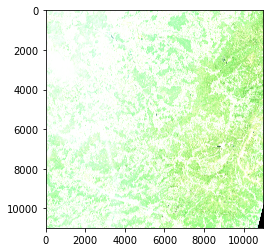

In [7]:
# Recreating an RGB image 
img = cv2.merge((band_dict["B04"], band_dict["B03"], band_dict["B02"]))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


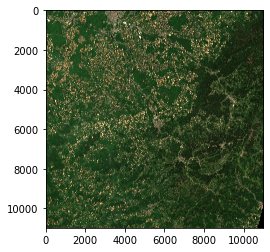

In [8]:
img_processed = img / 8
img_processed = img_processed.astype(int)
plt.imshow(img_processed)

# Step 4 - Splitting the images to machine learning ready sizes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


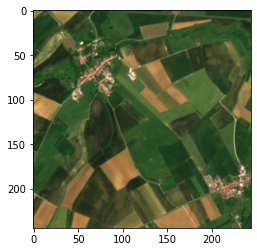

In [9]:
frag_count = 45
frag_size = int(img_processed.shape[0] / frag_count)
frag_dict = {}
    
for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = img_processed[y*frag_size: (y+1)*frag_size,  x*frag_size: (x+1)*frag_size, :]  
    
plt.imshow(frag_dict[(10, 10)])

# Step 5  - Link your data to the satellite images

In [10]:
def get_tci_file_path(image_folder):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R10m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == "TCI"][0]
            
    return f"{image_folder_path}/{selected_file}"

tci_file_path = get_tci_file_path(image_folder)

In [23]:
# Testing with the center of fragment 10, 10
pixel_column = int(frag_size * 10.5)
pixel_row = int(frag_size * 10.5)
print(f"pixel_column: {pixel_column}")
print(f"pixel_row: {pixel_row}")

pixel_column: 2562
pixel_row: 2562


### Obtaining metadata

In [24]:
transform = rasterio.open(tci_file_path, driver='JP2OpenJPEG').transform
zone_number = int(tci_file_path.split("/")[-1][1:3])
zone_letter = tci_file_path.split("/")[-1][0]

utm_x, utm_y = transform[2], transform[5]

### From pixel position to latitude/longitude 

In [25]:
# Converting pixel position to utm 
east = utm_x + pixel_column * 10 
north = utm_y + pixel_row * - 10

# Converting UTM to latitude and longitude
latitude, longitude = utm.to_latlon(east, north, zone_number, zone_letter)

In [26]:
print(f"latitude, longitude: {latitude}, {longitude} ")

latitude, longitude: 48.48203231430426, 6.05276181631565 


### From latitude/longitude to pixel position

In [27]:
# Converting  latitude and longitude to UTM
east, north, zone_number, zone_letter = utm.from_latlon(latitude, longitude, force_zone_number=zone_number)

# Converting  UTM to column and row
pixel_column = round((east - utm_x) / 10)
pixel_row = round((north - utm_y) / - 10)

In [28]:
print(f"pixel_column: {pixel_column}")
print(f"pixel_row: {pixel_row}")

pixel_column: 2562
pixel_row: 2562
